In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change path according to your local path
datasetZipFolder = "/content/drive/MyDrive/IoT DA/Behavioral-Context-Recognition-main/datasetExtrasensory"
datasetFolder = "/content/drive/MyDrive/IoT DA/Behavioral-Context-Recognition-main/datasetExtrasensory/"
datasetFolds = "/content/drive/MyDrive/IoT DA/Behavioral-Context-Recognition-main/cv_5_folds"

**Let's define some methods that we can use to parse the csv files**


In [ ]:
import numpy as np;


try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')];
    columns = headline.split(',');

    # The first column should be timestamp:
    assert columns[0] == 'timestamp';
    # The last column should be label_source:
    assert columns[-1] == 'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith('label:');
        label_names[li] = label.replace('label:','');
        pass;
    
    return (feature_names,label_names);



def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);



**Another method that we can use in order to obtain data about a single user**

In [ ]:
'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''

import gzip;

def read_user_data(uuid):
    user_data_file = datasetFolder + '%s.features_labels.csv.gz' % uuid;
  

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        csv_str = csv_str.decode("utf-8")
        pass;

    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

# 1st study

Let's try to read data about a single randomly chosen user and extract some information

In [ ]:
uuid = '00EABED2-271D-49D8-B599-1D4A09240601';
X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid);

Since there are some labels with standardized names, let's prettify them with this method

In [ ]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [ ]:
n_examples_per_label = np.sum(Y,axis=0);
labels_and_counts = zip(label_names,n_examples_per_label);
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
print("How many examples does this user have for each contex-label:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
    print("label %s - %d minutes" % (get_label_pretty_name(label),count))
    pass;

How many examples does this user have for each contex-label:
--------------------
label Phone on table - 1594 minutes
label Indoors - 1284 minutes
label Sitting - 1106 minutes
label At home - 995 minutes
label Lying down - 657 minutes
label Sleeping - 477 minutes
label With co-workers - 331 minutes
label In a meeting - 306 minutes
label In class - 214 minutes
label At main workplace - 197 minutes
label Standing - 193 minutes
label Walking - 163 minutes
label Computer work - 89 minutes
label Cooking - 55 minutes
label Eating - 54 minutes
label On a bus - 49 minutes
label Cleaning - 38 minutes
label Shopping - 19 minutes
label Dressing - 17 minutes
label Bathing - shower - 15 minutes
label Watching TV - 2 minutes
label Running - 0 minutes
label Bicycling - 0 minutes
label Lab work - 0 minutes
label Outside - 0 minutes
label In a car - 0 minutes
label Drive - I'm the driver - 0 minutes
label Drive - I'm a passenger - 0 minutes
label At a restaurant - 0 minutes
label Phone in pocket - 0 mi

**Let's find more details.**

We want to study and find differences between data coming from 2 different macro-groups of labels: labels identifying apparent static behaviours (like 'sitting') and once identifying apparent dynamic behaviours (like 'at the gym').


In [ ]:
static_labels = ['Sitting', 'Lying down', 'Sleeping', 'In a meeting', 'In class', 'Computer work', 'Watching TV', 'Drive - I\'m a passenger']

In [ ]:
movement_labels = ['Walking', 'Cooking', 'Cleaning', 'Shopping', 'Running', 'Bicycling', 'Drive - I\'m the driver', 'Strolling', 
                   'Doing laundry', 'At the gym', 'Stairs - going up', 'Stairs - going down']


In [ ]:
other_labels = []

for label,count in (sorted_labels_and_counts):
  if get_label_pretty_name(label) not in static_labels and get_label_pretty_name(label) not in movement_labels: 
    other_labels.append(get_label_pretty_name(label))

print(other_labels)

['Phone on table', 'Indoors', 'At home', 'With co-workers', 'At main workplace', 'Standing', 'Eating', 'On a bus', 'Dressing', 'Bathing - shower', 'Lab work', 'Outside', 'In a car', 'At a restaurant', 'Phone in pocket', 'Exercise', 'Drinking (alcohol)', 'Washing dishes', 'Surfing the internet', 'At a party', 'At a bar', 'At the beach', 'Singing', 'Talking', 'Toilet', 'Grooming', 'Elevator', 'At school', 'Phone in hand', 'Phone in bag', 'With friends']


In [ ]:
movement_counter = 0
static_counter = 0
other_counter = 0

n_examples_per_label = np.sum(Y,axis=0);
labels_and_counts = zip(label_names,n_examples_per_label);
sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
print("How many examples does this user have for each contex-label:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
  if(get_label_pretty_name(label) in static_labels):
    print("[STATIC] %s - %d minutes" % (get_label_pretty_name(label),count))
    static_counter += count
  elif (get_label_pretty_name(label) in movement_labels):
    print("[MOVEMENT] %s - %d minutes" % (get_label_pretty_name(label),count))
    movement_counter+= count
  # else:
  #   print("[OTHER] %s - %d minutes" % (get_label_pretty_name(label),count))
       

How many examples does this user have for each contex-label:
--------------------
[STATIC] Sitting - 1106 minutes
[STATIC] Lying down - 657 minutes
[STATIC] Sleeping - 477 minutes
[STATIC] In a meeting - 306 minutes
[STATIC] In class - 214 minutes
[MOVEMENT] Walking - 163 minutes
[STATIC] Computer work - 89 minutes
[MOVEMENT] Cooking - 55 minutes
[MOVEMENT] Cleaning - 38 minutes
[MOVEMENT] Shopping - 19 minutes
[STATIC] Watching TV - 2 minutes
[MOVEMENT] Running - 0 minutes
[MOVEMENT] Bicycling - 0 minutes
[MOVEMENT] Drive - I'm the driver - 0 minutes
[STATIC] Drive - I'm a passenger - 0 minutes
[MOVEMENT] Strolling - 0 minutes
[MOVEMENT] Doing laundry - 0 minutes
[MOVEMENT] At the gym - 0 minutes
[MOVEMENT] Stairs - going up - 0 minutes
[MOVEMENT] Stairs - going down - 0 minutes


***TOTAL***
STATIC: 2851 minutes
MOVEMENT: 275 minutes


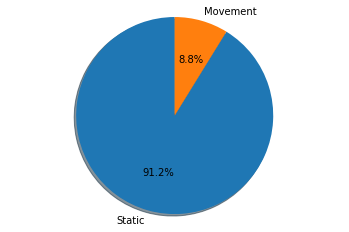

In [ ]:
print("***TOTAL***")
print("STATIC: %d minutes" %static_counter)
print("MOVEMENT: %d minutes" %movement_counter)


import matplotlib.pyplot as plt 

labels = 'Static', 'Movement'
sizes = [static_counter, movement_counter]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

We can immediately notice that this user passes more time doing static actions than the other ones. 

#**A MORE DETAILED VIEW: ALL USER INVOLVED**!

Since our final goal is to detect the static behaviours and the movement-ones, we are going to calculate the overall time spent doing each of those 2 behaviours by all the users involved in this study. 

In [ ]:
import glob 
import os 

all_users = []

for user_file in glob.glob(os.path.join(datasetFolder, '*.csv.gz')):
      user_file = user_file.replace(datasetFolder, "")
      uuid = user_file.replace(".features_labels.csv.gz", "")
      # print(uuid)
      X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid);
      all_users.append(Y)



In [ ]:
static_dictionary = {}
movement_dictionary = {}

for label in static_labels:
  static_dictionary[label] = 0

for label in movement_labels:
  movement_dictionary[label] = 0


print(static_dictionary)
print(movement_dictionary)

{'Sitting': 0, 'Lying down': 0, 'Sleeping': 0, 'In a meeting': 0, 'In class': 0, 'Computer work': 0, 'Watching TV': 0, "Drive - I'm a passenger": 0}
{'Walking': 0, 'Cooking': 0, 'Cleaning': 0, 'Shopping': 0, 'Running': 0, 'Bicycling': 0, "Drive - I'm the driver": 0, 'Strolling': 0, 'Doing laundry': 0, 'At the gym': 0, 'Stairs - going up': 0, 'Stairs - going down': 0}


In [ ]:
for i in range (0, len(all_users)):
  n_examples_per_label = np.sum(all_users[i],axis=0);

  labels_and_counts = zip(label_names,n_examples_per_label);
  sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1]);
  for (label,count) in sorted_labels_and_counts:
    label_pretty_name = get_label_pretty_name(label)
    if label_pretty_name in static_dictionary:
      static_dictionary[label_pretty_name] += count
    elif label_pretty_name in movement_dictionary:
      movement_dictionary[label_pretty_name] += count
    

print(static_dictionary)
print(movement_dictionary)
      

{'Sitting': 136356, 'Lying down': 104210, 'Sleeping': 83055, 'In a meeting': 5153, 'In class': 6110, 'Computer work': 38081, 'Watching TV': 13311, "Drive - I'm a passenger": 2526}
{'Walking': 22136, 'Cooking': 4029, 'Cleaning': 3806, 'Shopping': 1841, 'Running': 1090, 'Bicycling': 5020, "Drive - I'm the driver": 7975, 'Strolling': 806, 'Doing laundry': 556, 'At the gym': 1151, 'Stairs - going up': 798, 'Stairs - going down': 774}


In [ ]:
total_static = 0
for label in static_dictionary:
  total_static += static_dictionary[label]

total_movement = 0
for label in movement_dictionary:
  total_movement += movement_dictionary[label]

print(total_static)
print(total_movement)


388802
49982


***TOTAL***
STATIC: 388802 minutes
MOVEMENT: 49982 minutes


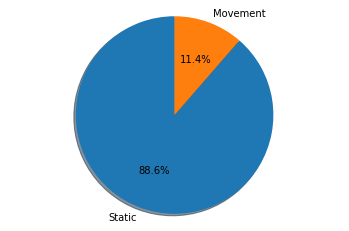

In [ ]:
print("***TOTAL***")
print("STATIC: %d minutes" %total_static)
print("MOVEMENT: %d minutes" %total_movement)

labels = 'Static', 'Movement'
sizes = [total_static, total_movement]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Confirmed: all users spend more time in static activities than movemented-ones.

#A MORE DETAILED VIEW


Let's see how the users spend their time performing specific activities that we grouped in static and movement categories.

In [ ]:

def get_counter_from(this_dictionary):
  sizes = []
  for label in this_dictionary:
    sizes.append(this_dictionary[label])

  return sizes



In [ ]:
static_labels = list(static_dictionary.keys())
static_sizes = get_counter_from(static_dictionary)

print(static_labels)
print(static_sizes)

['Sitting', 'Lying down', 'Sleeping', 'In a meeting', 'In class', 'Computer work', 'Watching TV', "Drive - I'm a passenger"]
[136356, 104210, 83055, 5153, 6110, 38081, 13311, 2526]


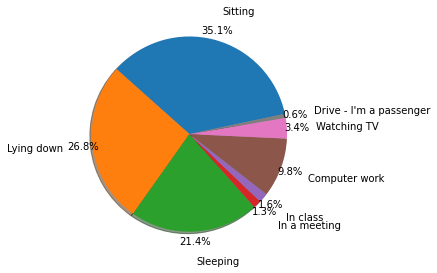

In [ ]:
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(static_sizes, labels=static_labels, autopct='%1.1f%%',
        shadow=True, pctdistance = 1.1, labeldistance = 1.3, startangle=12)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xticks(rotation='90')
plt.show()

**SITTING**  is the most common acitivty performed in the STATIC group of labels


Let's move on with the movement activities.

In [ ]:
movement_labels = list(movement_dictionary.keys())
movement_sizes = get_counter_from(movement_dictionary)

print(movement_labels)
print(movement_sizes)

['Walking', 'Cooking', 'Cleaning', 'Shopping', 'Running', 'Bicycling', "Drive - I'm the driver", 'Strolling', 'Doing laundry', 'At the gym', 'Stairs - going up', 'Stairs - going down']
[22136, 4029, 3806, 1841, 1090, 5020, 7975, 806, 556, 1151, 798, 774]


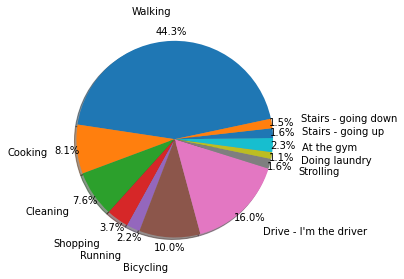

In [ ]:
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1.pie(movement_sizes, labels=movement_labels, autopct='%1.1f%%',
        shadow=True,pctdistance = 1.1, labeldistance = 1.3, startangle=12)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xticks(rotation='90')
plt.show()

**WALKING** is the most common activity performed in the MOVEMENT group labels.

# FIRST RECAP

We can see that, in the overall dataset, data referring to static behaviours are predominant with respect to the other ones.

At this point, the work requires further investigations: we want to detect the most influential features that clearly differentiate a static behaviour from a movement- one.

According to the studies conducted by Vaizman et al., there are different features that play a role as well: let's see them.

## Sensor features:
The features are less intuitive to interpret than the labels.
They were calculated from the fuller raw-measurements from the various sensors on the smartphone or smartwatch.

We can start by looking at the feature names, where the prefix of each feature indicates the sensor where it came from.
For convenience, we add a function to parse the feature names and provide the code-name of the sensor they belong to. We'll use the code-names as they appear in the original ExtraSensory paper:
Acc (phone-accelerometer), Gyro (phone-gyroscope), WAcc (watch-accelerometer), Loc (location), Aud (audio), and PS (phone-state).
Plus, the other sensors provided here that were not analyzed in the original paper: Magnet (phone-magnetometer), Compass 
(watch-compass), AP (audio properties, about the overall power of the audio), and LF (various low-frequency sensors).

In [ ]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names;

In [ ]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


**VERY IMPORTANT**

We are going to use these indices to refer to the features.



In [ ]:
import pandas as pd

df_list=[]
for gzFile in os.listdir(datasetZipFolder):
  gzPath = datasetZipFolder+"//"+gzFile
  with gzip.open(gzPath) as f:
      df = pd.read_csv(f, header=0)
      df.insert(0,'uuid',gzFile[:-23])
      df_list.append(df)

df_dset = pd.concat(df_list, axis=0, ignore_index=True)
df_dset.head()

,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,...,label:IN_A_CAR,label:ON_A_BUS,label:DRIVE_-_I_M_THE_DRIVER,label:DRIVE_-_I_M_A_PASSENGER,label:LOC_home,label:FIX_restaurant,label:PHONE_IN_POCKET,label:OR_exercise,label:COOKING,label:SHOPPING,label:STROLLING,label:DRINKING__ALCOHOL_,label:BATHING_-_SHOWER,label:CLEANING,label:DOING_LAUNDRY,label:WASHING_DISHES,label:WATCHING_TV,label:SURFING_THE_INTERNET,label:AT_A_PARTY,label:AT_A_BAR,label:LOC_beach,label:SINGING,label:TALKING,label:COMPUTER_WORK,label:EATING,label:TOILET,label:GROOMING,label:DRESSING,label:AT_THE_GYM,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,6.684605,5.043970,0.000042,0.000364,0.000761,0.005429,0.429853,0.173685,0.148988,0.002331,0.004614,-0.996790,0.003269,0.003521,0.003539,0.106920,0.516842,0.255494,0.002558,0.001510,0.001832,0.002531,0.001526,0.002196,0.003230,2.236059,6.532865,5.149616,2.818909,3.757026,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,6.684603,5.043367,0.000071,0.000468,0.000630,0.007756,0.429733,0.057819,0.207046,0.003557,0.005495,-0.996832,0.002489,0.003772,0.004177,-0.079483,0.357748,0.036252,0.002279,0.001256,0.001519,0.002183,0.001424,0.002035,0.002880,2.028993,6.550010,4.945471,2.153223,2.719359,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,6.684605,5.043599,0.000052,0.000251,0.000730,0.008223,0.429799,0.173440,0.186961,0.004180,0.005776,-0.996785,0.003567,0.004051,0.003681,0.122432,0.464881,0.222375,0.002579,0.001790,0.002418,0.003395,0.001350,0.002088,0.003187,1.975138,6.492197,4.878255,3.366933,3.824890,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,6.684605,5.043263,0.000019,0.000173,0.000623,0.003763,0.429628,0.173474,0.479430,0.004179,0.005551,-0.996836,0.004202,0.002919,0.003559,0.308841,0.773514,0.296194,0.00249

Let's consider data related to a single (randomly chosen) user:

In [ ]:
uuid = '00EABED2-271D-49D8-B599-1D4A09240601';
user_data = df_dset.loc[df_dset['uuid']==uuid]
user_data = user_data.copy()
user_data.reset_index(inplace=True,drop=True)
print(user_data.shape)
user_data.head()

(2287, 279)


,uuid,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,...,label:IN_A_CAR,label:ON_A_BUS,label:DRIVE_-_I_M_THE_DRIVER,label:DRIVE_-_I_M_A_PASSENGER,label:LOC_home,label:FIX_restaurant,label:PHONE_IN_POCKET,label:OR_exercise,label:COOKING,label:SHOPPING,label:STROLLING,label:DRINKING__ALCOHOL_,label:BATHING_-_SHOWER,label:CLEANING,label:DOING_LAUNDRY,label:WASHING_DISHES,label:WATCHING_TV,label:SURFING_THE_INTERNET,label:AT_A_PARTY,label:AT_A_BAR,label:LOC_beach,label:SINGING,label:TALKING,label:COMPUTER_WORK,label:EATING,label:TOILET,label:GROOMING,label:DRESSING,label:AT_THE_GYM,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,00EABED2-271D-49D8-B599-1D4A09240601,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,6.684605,5.043970,0.000042,0.000364,0.000761,0.005429,0.429853,0.173685,0.148988,0.002331,0.004614,-0.996790,0.003269,0.003521,0.003539,0.106920,0.516842,0.255494,0.002558,0.001510,0.001832,0.002531,0.001526,0.002196,0.003230,2.236059,6.532865,5.149616,2.818909,3.757026,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,00EABED2-271D-49D8-B599-1D4A09240601,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,6.684603,5.043367,0.000071,0.000468,0.000630,0.007756,0.429733,0.057819,0.207046,0.003557,0.005495,-0.996832,0.002489,0.003772,0.004177,-0.079483,0.357748,0.036252,0.002279,0.001256,0.001519,0.002183,0.001424,0.002035,0.002880,2.028993,6.550010,4.945471,2.153223,2.719359,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,00EABED2-271D-49D8-B599-1D4A09240601,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,6.684605,5.043599,0.000052,0.000251,0.000730,0.008223,0.429799,0.173440,0.186961,0.004180,0.005776,-0.996785,0.003567,0.004051,0.003681,0.122432,0.464881,0.222375,0.002579,0.001790,0.002418,0.003395,0.001350,0.002088,0.003187,1.975138,6.492197,4.878255,3.366933,3.824890,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,00EABED2-271D-49D8-B599-1D4A09240601,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,6.684605,5.043263,0.000019,0.000173,0.000623,0.003763,0.429628,0.173474,0.479430,0.004179,0.005551,-0.996836,0.004202,0.002919,0.003559,0.308841,0.773514,0.296194,0.00249

### Knowing this, let's consider some potentially important features that must be useful to detect different behaviours and let's see how they vary overtime, performing a specific kind of activity.

To start let's define a function that takes as input 2 LABELS (which we want to compare) and the feauture's index that we want to analyze (the feature index is taken from the list of features above)

In [ ]:
import math
from matplotlib.ticker import FormatStrFormatter


def extract_data_and_graph(first_label,second_label, feature_index):
  
  user_data_sitting = user_data.loc[user_data["label:"+first_label]==1].copy()
  timestamps_sitting = user_data_sitting['timestamp']
  user_data_walking = user_data.loc[user_data["label:"+second_label]==1].copy()
  timestamps_walking = user_data_walking['timestamp']

  # print(timestamps_sitting)
  # print("----")
  # print(timestamps_walking)
  # print(timestamps_walking[0])

  # print(user_data_sitting)
  # print(user_data_walking)

  feat_values_sitting = user_data_sitting.iloc[:,feature_index+2:feature_index+3]
  feat_values_walking = user_data_walking.iloc[:,feature_index+2:feature_index+3]


  feat_values_sitting = feat_values_sitting[~np.isnan(feat_values_sitting)]
  feat_values_sitting = feat_values_sitting[feat_values_sitting>0]

  feat_values_walking = feat_values_walking[~np.isnan(feat_values_walking)]
  feat_values_walking = feat_values_walking[feat_values_walking>0]

  # print(feat_values_walking)

  # seconds_in_day = (60*60*24);
  days_since_participation_2= (timestamps_walking - timestamps_walking.iloc[0]) / float(60*60*24);
  days_since_participation = (timestamps_sitting - timestamps_sitting[0]) / float(60*60*24);
  # print(days_since_participation)
  # print(days_since_participation_2)


  lastXValue = (int(max(days_since_participation.iloc[-1],days_since_participation_2.iloc[-1])))
  maxYValue = (max(float(feat_values_walking.max()), float(feat_values_sitting.max())))
  minYValue = (min(float(feat_values_walking.min()), float(feat_values_sitting.min())))
  # print(maxYValue)
  # print(minYValue)
  # print(truncate(maxYValue, 4))
  # print(math.floor(minYValue))
  # print(math.ceil(maxYValue))

  fig = plt.figure(figsize=(25,6));

  ax1 = plt.subplot(1,2,1);

  ax1.plot(days_since_participation, feat_values_sitting, 'ro');
  plt.ylabel(first_label + "  VALUES");
  plt.xlabel('days');
  plt.xticks(range(0,lastXValue+1))
  plt.xlim(-1, lastXValue+1) 
  ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # plt.yticks(range(minYValue, maxYValue))
  # print(minYValue, maxYValue)
  if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
    plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)
  # print(minYValue, maxYValue)


  # plt.title('%d) %s\nfunction of time' % (ind,feature));

  ax1 = plt.subplot(1,2,2);
  ax1.plot(days_since_participation_2,feat_values_walking, 'ro');
  plt.ylabel(second_label+"  VALUES");
  plt.xlabel('days');
  plt.xticks(range(0,lastXValue+1))
  plt.xlim(-1, lastXValue+1)
  ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # plt.yticks(range(minYValue, maxYValue))
  if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
    plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)




  fig = plt.figure(figsize=(10,6));

  ax3 = plt.subplot(1,1,1);
  plt.autoscale()
  to_boxplot1 = feat_values_sitting[feat_values_sitting.columns[0]].values
  to_boxplot2 = feat_values_walking[feat_values_walking.columns[0]].values
  # print(to_boxplot1.shape)
  to_boxplot1 = to_boxplot1[~np.isnan(to_boxplot1)]
  to_boxplot2 = to_boxplot2[~np.isnan(to_boxplot2)]

  ax3.boxplot([to_boxplot1, to_boxplot2], labels = [first_label, second_label])
  plt.autoscale()
  # # plt.title('%d) %s\nhistogram' % (ind,feature));


Let's compare the value distribution of the mean of the raw acceleration between the data labeled as SITTING and the data labeled as WALKING of this user (why these 2 labels? Because they are the most common activities performed by the users of this work)



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


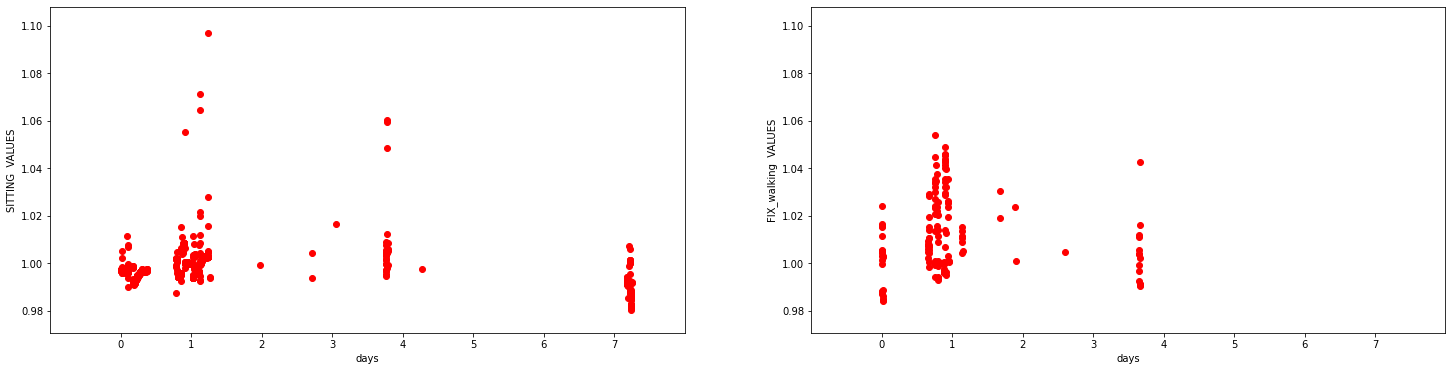

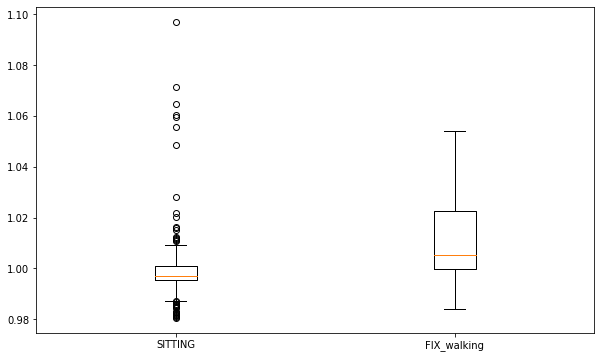

In [ ]:
#raw acceleration mean : its index is 0
extract_data_and_graph("SITTING", "FIX_walking", feature_index = 0)

**[1ST and 2 GRAPH] DURING THE SITTING EVENTS, the values are more NUMEROUS than the WALKING EVENTS: maybe this user typycally remember to use the ExtraSensory app to describe its activity while he's sitting, while for the WALKING EVENTS he sometimes forgets to do the labeling activity.**

**[BOXPLOTS] We can also say that the WALKING VALUES are more SCATTERED and HIGHER with respect to the SITTING VALUES: it seems clear that the majority of SITTING VALUES (the box, that contains the central 50% of the observations made) is all concentrated before 1.00, while the box of WALKING VALUES is greater and concentrated between 1.00 and 1.02**

**The two segments that start from the box and extend upwards and downwards the box are called "whiskers". Whiskers indicate the dispersion of values below the first quartile and above the third quartile
NOT CLASSIFIED AS OUTLIERS: the upper whisker of WALKING GRAPH is longer than the upper whisker of the other graph, in which we found different OUTLIERS, isolated points too diverse than the rest**

**WHY NO OUTLIERS in WALKING GRAPH? Becuase the values are similar to each other, with respect to the SITTING VALUES in which we found isolated and oddly higher values with respect to the majority**

Now let's compare the watch acceleration mean between the same labeled data (SITTING and WALKING)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


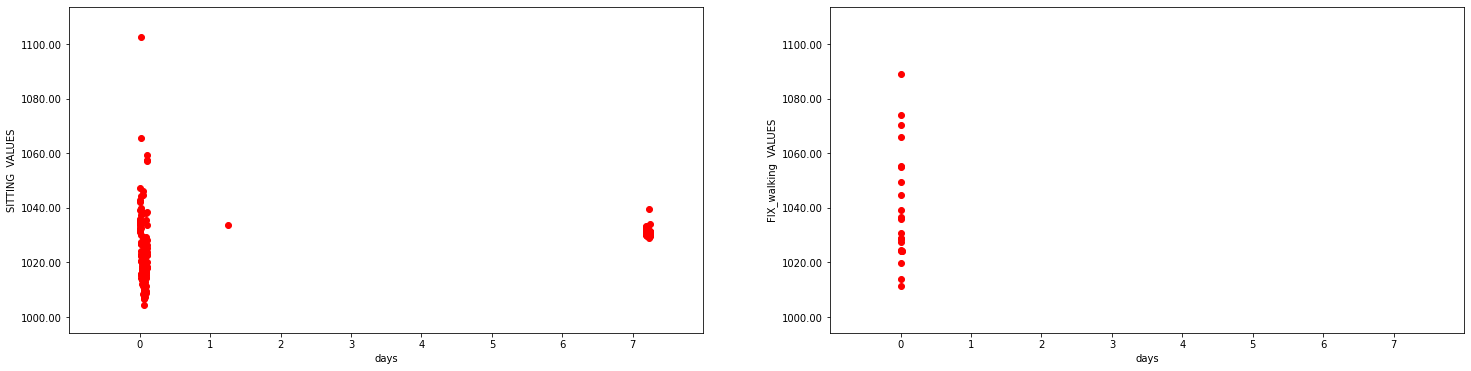

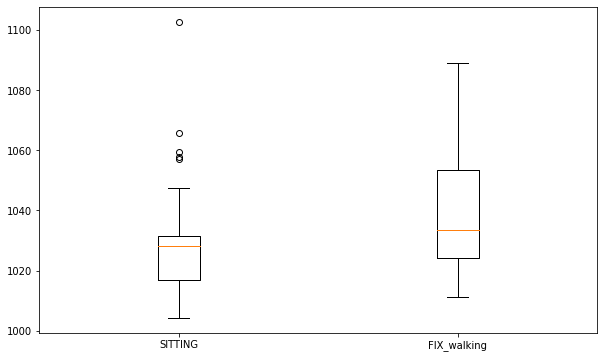

In [ ]:
#watch acceleration mean : its index is 83
extract_data_and_graph("SITTING", "FIX_walking", feature_index = 83)

**Different feature, but almost the same behaviour: WALKING VALUES MORE SCATTERED, LESS in quantity but GREATER in value.**
**WALKING'S BOX greater than SITTING'S BOX, with LONGER whiskers and NO OUTLIERS**

What about the min_speed and max_speed of this user, during the SITTING or WALKING EVENTS? 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


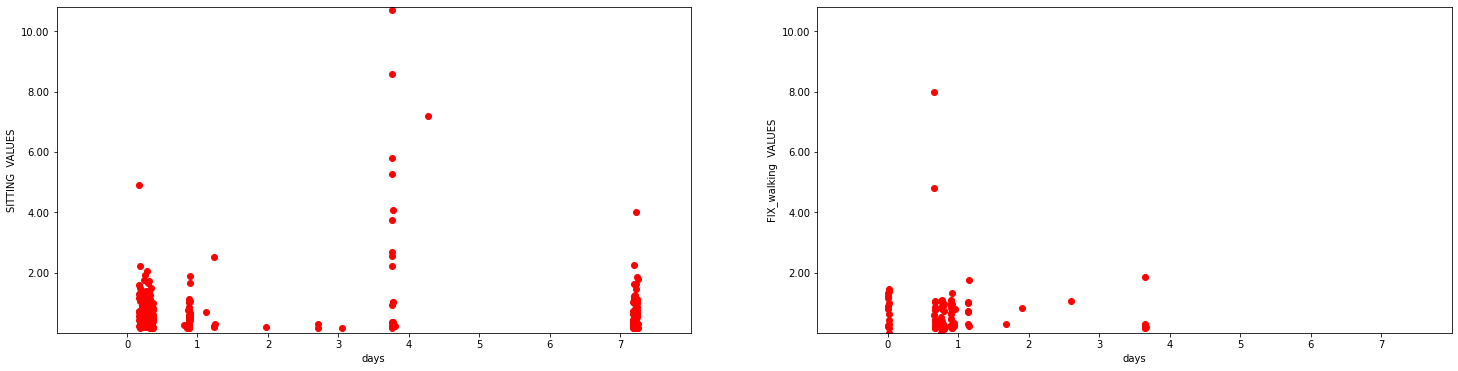

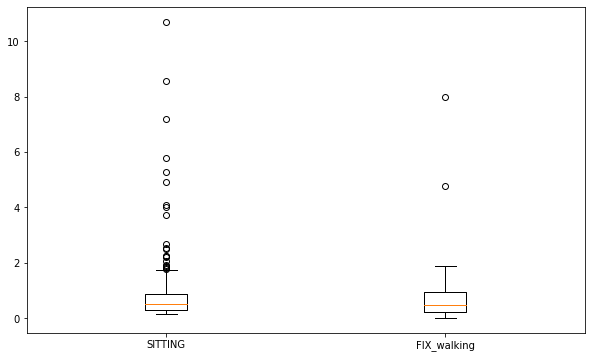

In [ ]:
# location:min_speed: its index is 143
extract_data_and_graph("SITTING", "FIX_walking", feature_index = 143)


**The values of min_speed are almost the same for both the labels, but surprisingly for the SITTING ACTIVITES there are higher values than the WALKING ones.**

Let's see what happens with the max_speed.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


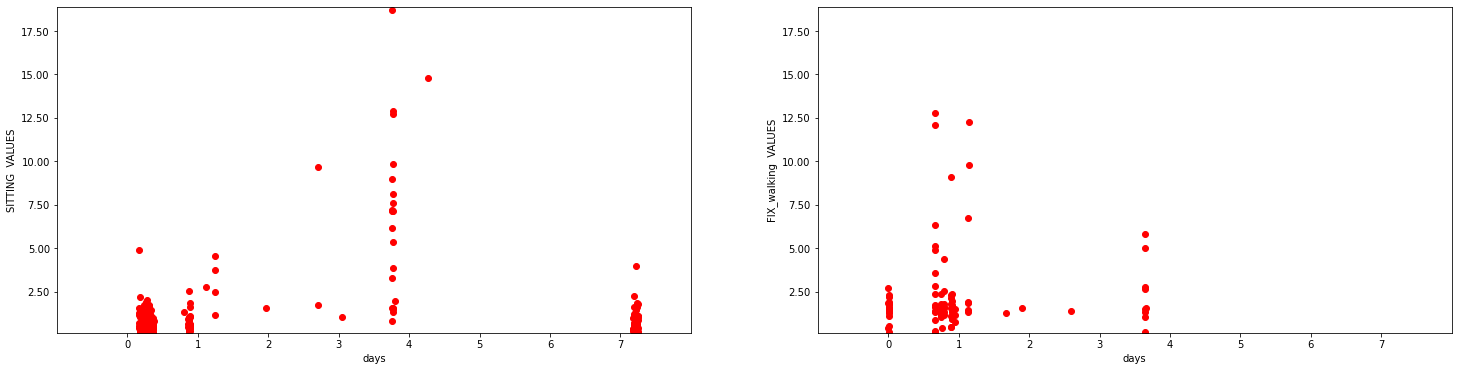

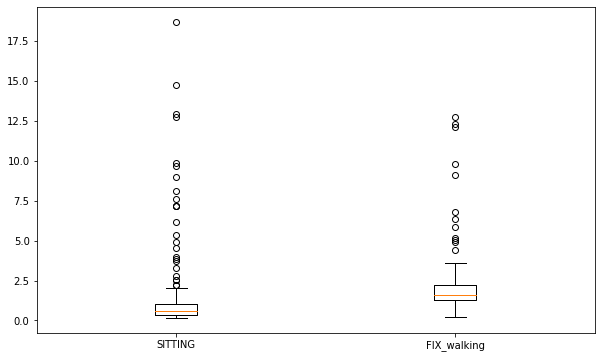

In [ ]:
# location:max_speed: its index is 144
extract_data_and_graph("SITTING", "FIX_walking", feature_index = 144)


**Here we have an expected behaviour: the values are more numerous for the SITTING activites than the WALKING ones as always, but the boxplots are telling us that almost the majority of the WALKING values is concentrated around 2.0, while for the SITTING ones we have clearly lower values.**

(NOw, let's compare the audio values: keep in mind that, related to the audio feature, we have 13 different columns, each of those describing a MFC coefficient.

The Mel-Frequency Cepstract coefficients describe some caratheristics related to the audio recorded. Here we have 13 coefficients because usually 12-13 coefficients keep the most relevant information)


Nowe let's compare the maximum audio abs_value!

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


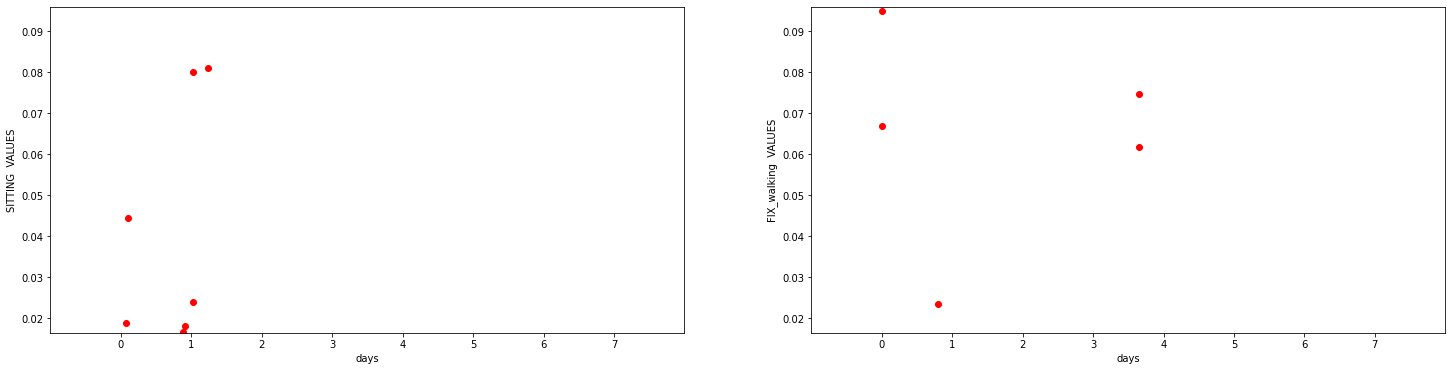

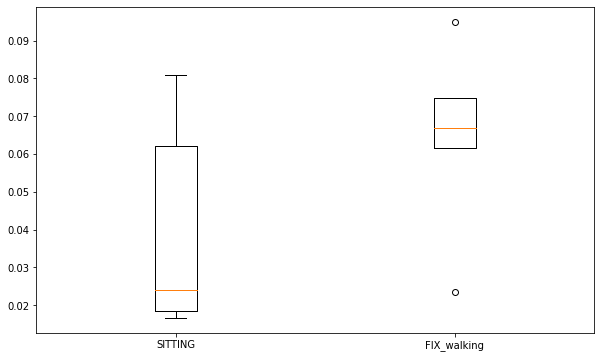

In [ ]:
#  audio_properties:max_abs_value: its index is 181
extract_data_and_graph("SITTING", "FIX_walking", feature_index = 181)


In this case we have only a few data available: in order to have a meaningful analysis, we will analyze data of more than one user, with more that 2 labels mentioned as examples up to now.

Finally let's see what happens with the battery indicatory of the user's phone: a feature that in our opinion can be important since it can be useful to identify a WALKING behaviour from a SITTING one. This hypothesys comes from the assumption that when the user is sitting, he's SURELY not at home. At home it's reasonable that he just charged the phone, or he's charging it in the right moment that he's performing the labeling activity on the Extrasensory app. 

**And so the battery level during SITTING events can be HIGHER with repsect to the battery level during WALKING events.  

Let's see if the plot is telling us something useful 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


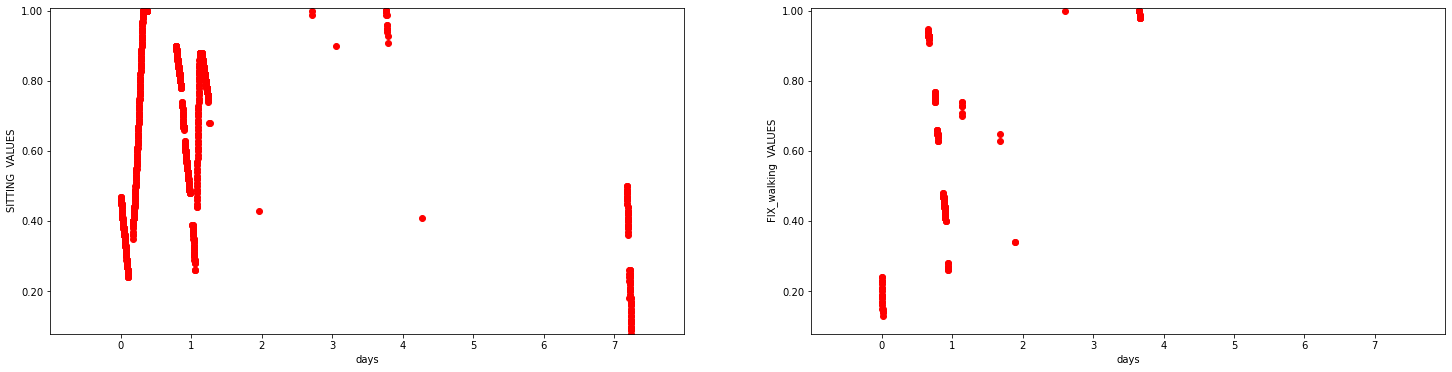

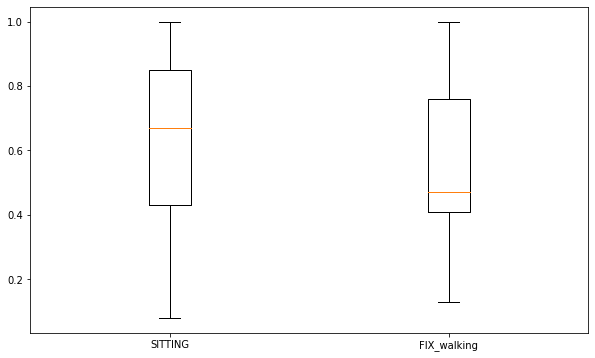

In [ ]:
# lf_measurements:battery_level: its index is 214

extract_data_and_graph("SITTING", "FIX_walking", feature_index = 214)


There are, as always, more values for the SITTING activity than WALKING one. 
As expected, the boxplot of the SITTING data is concentrated around values generally higher than WALKING ONE.





#2nd study

As first study we conducted this brief analysis regarding data of a single user, taking into consideration only the most important label of the 2 macrogroups of labels that we create: SITTING for the STATIC group, WALKING for the MOVEMENT one.

To have a more precise view of the data, let's go to expand this analysis: we are going to take into consideration ALL THE USERS and ALL THE LABELS of the 2 macrogrups, making a comparison between them.



In [ ]:
for user_file in glob.glob(os.path.join(datasetFolder, '*.csv.gz')):
      user_file = user_file.replace(datasetFolder, "")
      uuid = user_file.replace(".features_labels.csv.gz", "")
      print(uuid)

00EABED2-271D-49D8-B599-1D4A09240601
0A986513-7828-4D53-AA1F-E02D6DF9561B
098A72A5-E3E5-4F54-A152-BBDA0DF7B694
0BFC35E2-4817-4865-BFA7-764742302A2D
0E6184E1-90C0-48EE-B25A-F1ECB7B9714E
1155FF54-63D3-4AB2-9863-8385D0BD0A13
11B5EC4D-4133-4289-B475-4E737182A406
136562B6-95B2-483D-88DC-065F28409FD2
1538C99F-BA1E-4EFB-A949-6C7C47701B20
1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842
24E40C4C-A349-4F9F-93AB-01D00FB994AF
2C32C23E-E30C-498A-8DD2-0EFB9150A02E
27E04243-B138-4F40-A164-F40B60165CF3
33A85C34-CFE4-4732-9E73-0A7AC861B27A
3600D531-0C55-44A7-AE95-A7A38519464E
40E170A7-607B-4578-AF04-F021C3B0384A
481F4DD2-7689-43B9-A2AA-C8772227162B
4E98F91F-4654-42EF-B908-A3389443F2E7
4FC32141-E888-4BFF-8804-12559A491D8C
5119D0F8-FCA8-4184-A4EB-19421A40DE0D
5152A2DF-FAF3-4BA8-9CA9-E66B32671A53
59818CD2-24D7-4D32-B133-24C2FE3801E5
5EF64122-B513-46AE-BCF1-E62AAC285D2C
59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2
61359772-D8D8-480D-B623-7C636EAD0C81
61976C24-1C50-4355-9C49-AAE44A7D09F6
665514DE-49DC-421F-8DCB-145D0B2609AD
7

In [ ]:
import pandas as pd

df_list=[]
for gzFile in os.listdir(datasetZipFolder):
  gzPath = datasetZipFolder+"//"+gzFile
  with gzip.open(gzPath) as f:
      df = pd.read_csv(f, header=0)
      df.insert(0,'uuid',gzFile[:-23])
      df_list.append(df)

df_dset = pd.concat(df_list, axis=0, ignore_index=True)
print(df_dset)

                                        uuid  ...  label_source
0       00EABED2-271D-49D8-B599-1D4A09240601  ...             2
1       00EABED2-271D-49D8-B599-1D4A09240601  ...             2
2       00EABED2-271D-49D8-B599-1D4A09240601  ...             2
3       00EABED2-271D-49D8-B599-1D4A09240601  ...             2
4       00EABED2-271D-49D8-B599-1D4A09240601  ...             2
...                                      ...  ...           ...
377341  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377342  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377343  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377344  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1
377345  FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF  ...            -1

[377346 rows x 279 columns]


In [ ]:
user_data = []

# for label in static_labels:
#   user_data += df_dset.loc[df_dset["label:"+label]==1]

for col in df_dset.columns:
  if(col.startswith("label:") ):
    temp_label = col.replace("label:", "")
    # print(temp_label)
    temp_label = get_label_pretty_name(temp_label)       
    # print(temp_label)
    if(temp_label in static_labels or temp_label in movement_labels):
      # print(temp_label)
      # print(col, temp_label)
      df_dset = df_dset.rename(columns = {col: temp_label})
    else:
      # print(temp_label)
      df_dset = df_dset.drop(columns=[col])



Now let's define a method that, from this dataset, takes data related to a specific features and compare the behaviour of ALL user performing always the 2 most important labels tha ìt we encountered: SITTING and WALKING

The difference with the previous method that compared data of a single user is that in that case we used a boxplot to analyze the feature's distribution.

In this case, since the value are MORE NUMEROUS, we can't use a boxplot: we are going to use a histogram, that anyway it's a graphical representation of a distribution in classes  

In [ ]:
def extract_data_and_graph_ALL(feature_index):
  
  temp_user_data_static = []
  single_user_data_static = []
  users_data_static = []

  personal_timestamp = []
  cleaned_personal_timestamp = []
  temp_timestamps_static = []
  timestamps_static = []

  temp_user_data_movement = []
  single_user_data_movement = []
  users_data_movement = []

  personal_timestamp_movement = []
  cleaned_personal_timestamp_movement = []
  temp_timestamps_movement = []
  timestamps_movement = []


  label = "Sitting"
      
  temp_user_data_static = []
  #selecting subset of dataset with a specific label
  temp_user_data_static = (df_dset.loc[df_dset[label]==1])
  # print(temp_user_data_static)
  #getting all uuid that identify users in this subset of data
  uuid_list = (temp_user_data_static['uuid'].unique())
  for uuid in uuid_list:
    # print("utente"+str(uuid))
    #selecting subset of dataset with a sepcific label and a specific uuid
    single_user_data_static = temp_user_data_static[temp_user_data_static['uuid']==uuid]
    #selecting the correspondent timestamp
    personal_timestamp = (temp_user_data_static[temp_user_data_static['uuid']==uuid]['timestamp'])
    #clean and prepare the timestamp for the plot
    cleaned_personal_timestamp = ((personal_timestamp - personal_timestamp.iloc[0])/float(60*60*24))
    # print(cleaned_personal_timestamp)
    temp_timestamps_static.append(cleaned_personal_timestamp)
    users_data_static.append(single_user_data_static)

  # print(len(users_data_static))
  # temp_timestamps_static = ((temp_timestamps_static - temp_timestamps_static[0][0])/float(60))
  df_static = pd.concat(users_data_static, axis=0, ignore_index=True)
  tp_static = pd.concat(temp_timestamps_static, axis = 0, ignore_index = True)
  # print(len(df_static.index))
  # print(statistics.mean(tp_static))

  feat_values_firstLabel = df_static.iloc[:,feature_index+2:feature_index+3]
  feat_values = feat_values_firstLabel[feat_values_firstLabel.columns[0]].to_numpy()

  # print(feat_values)


  indexToNotConsider = [i for i in range(len(tp_static)) if tp_static[i] > 100]
  for i in (indexToNotConsider):
    del tp_static[i]

  # print(indexToNotConsider)
  cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # print(cleaned_feat_values.shape)

  #**************#**************#**************#**************#**************#**************#**************#**************#**************#**************#**************#**************

  label = 'Walking'
  temp_user_data_movement = []
  #selecting subset of dataset with a specific label
  temp_user_data_movement = (df_dset.loc[df_dset[label]==1])
  # print(temp_user_data_static)
  #getting all uuid that identify users in this subset of data
  uuid_list = (temp_user_data_movement['uuid'].unique())
  for uuid in uuid_list:
    # print("utente"+str(uuid))
    #selecting subset of dataset with a sepcific label and a specific uuid
    single_user_data_movement = temp_user_data_movement[temp_user_data_movement['uuid']==uuid]
    #selecting the correspondent timestamp
    personal_timestamp_movement = (temp_user_data_movement[temp_user_data_movement['uuid']==uuid]['timestamp'])
    #clean and prepare the timestamp for the plot
    cleaned_personal_timestamp_movement = ((personal_timestamp_movement - personal_timestamp_movement.iloc[0])/float(60*60*24))
    # print(cleaned_personal_timestamp)
    temp_timestamps_movement.append(cleaned_personal_timestamp_movement)
    users_data_movement.append(single_user_data_movement)

  # print(len(users_data_static))
  # temp_timestamps_static = ((temp_timestamps_static - temp_timestamps_static[0][0])/float(60))
  df_movement = pd.concat(users_data_movement, axis=0, ignore_index=True)
  tp_movement = pd.concat(temp_timestamps_movement, axis = 0, ignore_index = True)
  # print(len(df_static.index))
  # print(statistics.mean(tp_static))

  feat_values_secondLabel = df_movement.iloc[:,feature_index+2:feature_index+3]
  feat_values2 = feat_values_secondLabel[feat_values_secondLabel.columns[0]].to_numpy()

  # print(feat_values)


  indexToNotConsider2 = [i for i in range(len(tp_movement)) if tp_movement[i] > 100]
  for i in (indexToNotConsider2):
    del tp_movement[i]

  # print(indexToNotConsider)
  cleaned_feat_values2 = np.delete(feat_values2, indexToNotConsider2)

  # cleaned_feat_values = np.delete(feat_values, indexToNotConsider)

  # print(cleaned_feat_values.shape)

  # print(cleaned_feat_values)
  # print(cleaned_feat_values2)

  fig = plt.figure(figsize=(25,6));

  ax1 = plt.subplot(1,2,1);

  ax1.plot(tp_static, cleaned_feat_values, 'ro');
  plt.ylabel("SITTING  VALUES");
  plt.xlabel('days');
  # # plt.xticks(range(0,lastXValue+1))
  # # plt.xlim(-1, lastXValue+1) 
  # # ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # # # plt.yticks(range(minYValue, maxYValue))
  # # print(minYValue, maxYValue)
  # # if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
  # #   plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)
  # # print(minYValue, maxYValue)


  # # # plt.title('%d) %s\nfunction of time' % (ind,feature));

  ax1 = plt.subplot(1,2,2);
  ax1.plot(tp_movement,cleaned_feat_values2, 'ro');
  plt.ylabel("WALKING VALUES");
  plt.xlabel('days');
  # # plt.xticks(range(0,lastXValue+1))
  # # plt.xlim(-1, lastXValue+1)
  # # ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  
  # # # plt.yticks(range(minYValue, maxYValue))
  # # if(not(math.isnan(minYValue)) and not(math.isnan(maxYValue))):
  # #   plt.ylim(minYValue-minYValue/100, maxYValue+maxYValue/100)




  fig = plt.figure(figsize=(25,6));

  ax3 = plt.subplot(1,2,1);

  q25, q75 = np.nanpercentile(cleaned_feat_values, [25, 75])
  values_shape = cleaned_feat_values.shape
  bin_width = 2 * (q75 - q25) * (values_shape[0]) ** (-1/3)
  # print(q75, q25, np.nanmax(cleaned_feat_values))
  bins = round((np.nanmax(cleaned_feat_values) - np.nanmin(cleaned_feat_values)) / bin_width)
  # print("Freedman–Diaconis number of bins:", bins)
  plt.hist(cleaned_feat_values, density=True, bins=bins)
  plt.ylabel("FREQUENCY")
  plt.xlabel("CLASSES")
  plt.autoscale()


  ax3 = plt.subplot(1,2,2);

  q25_2, q75_2 = np.nanpercentile(cleaned_feat_values2, [25, 75])
  values_shape2 = cleaned_feat_values2.shape
  bin_width2 = 2 * (q75_2 - q25_2) * (values_shape2[0]) ** (-1/3)
  # print(q75_2, q25_2, np.nanmax(cleaned_feat_values2))
  bins2 = round((np.nanmax(cleaned_feat_values2) - np.nanmin(cleaned_feat_values2)) / bin_width2)
  # print("Freedman–Diaconis number of bins:", bins)
  plt.hist(cleaned_feat_values2, density=True, bins=bins2)
  plt.ylabel("FREQUENCY")
  plt.xlabel("CLASSES")
  plt.autoscale()

As before, lets start considering the acceleration mean

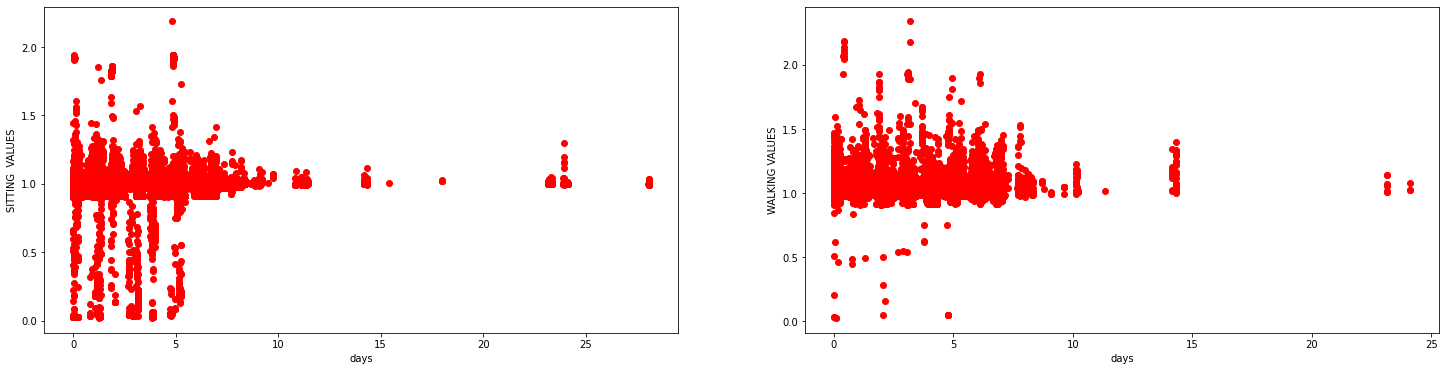

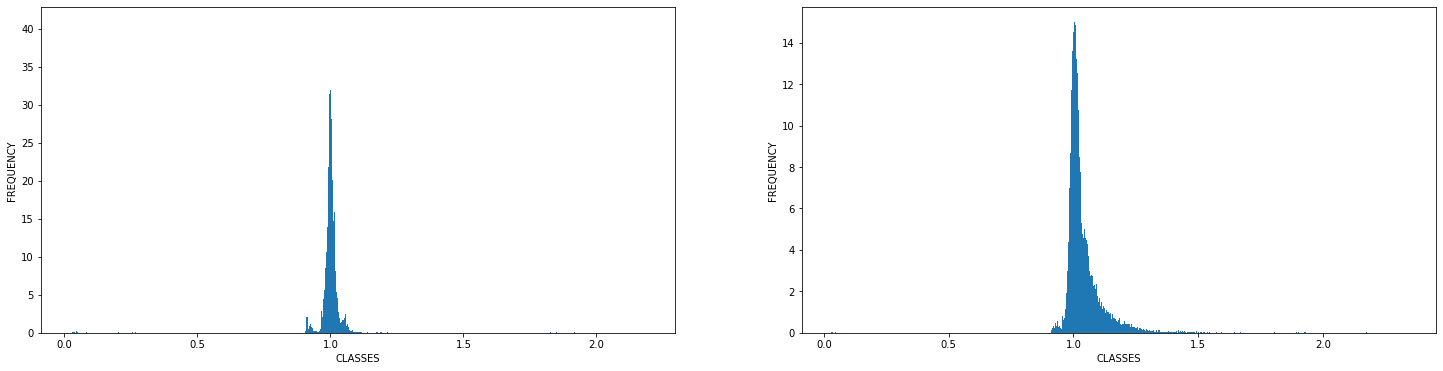

In [ ]:
#raw acceleration mean : its index is 0
extract_data_and_graph_ALL(0)

As before, the values are generally higher for the WALKING activity.

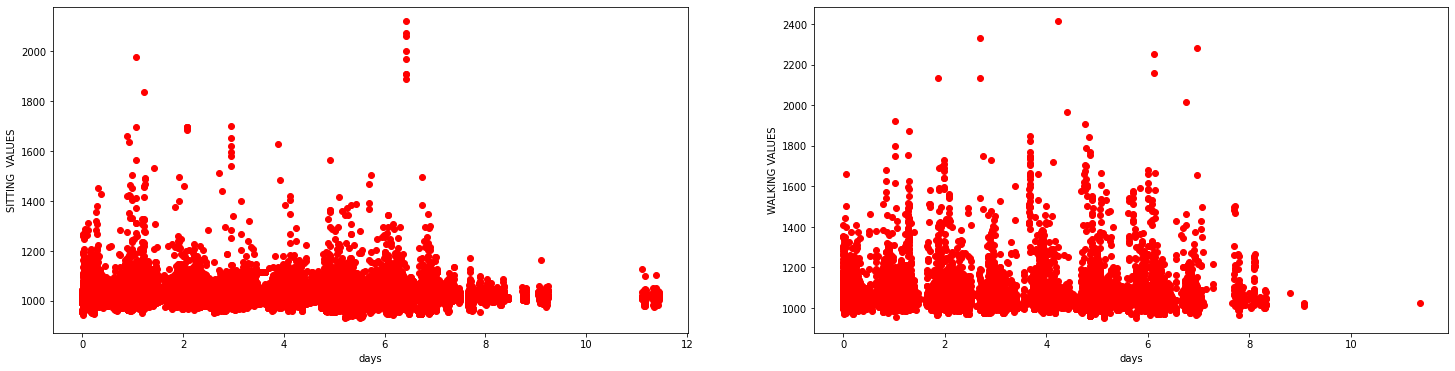

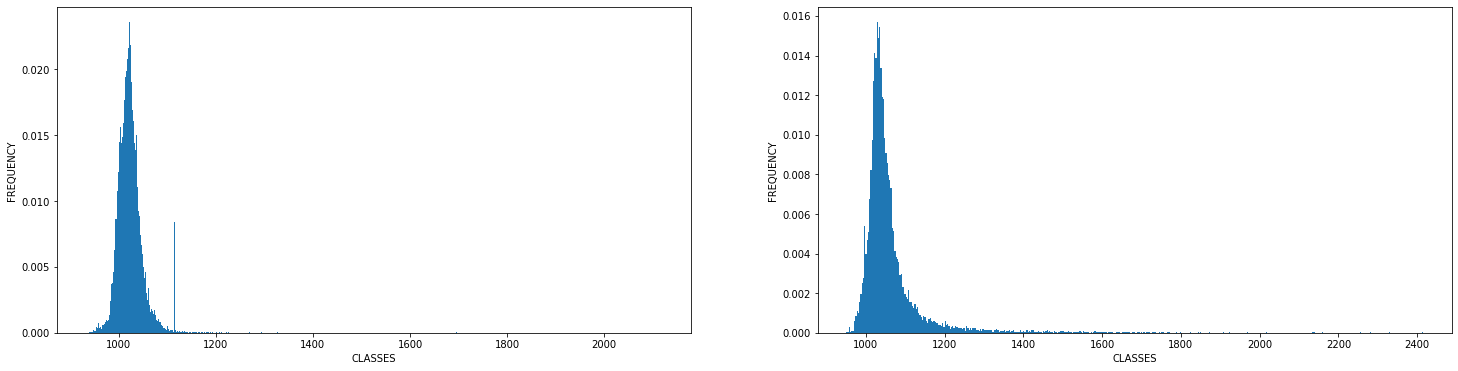

In [ ]:
#watch acceleration mean : its index is 83
extract_data_and_graph_ALL(feature_index = 83)

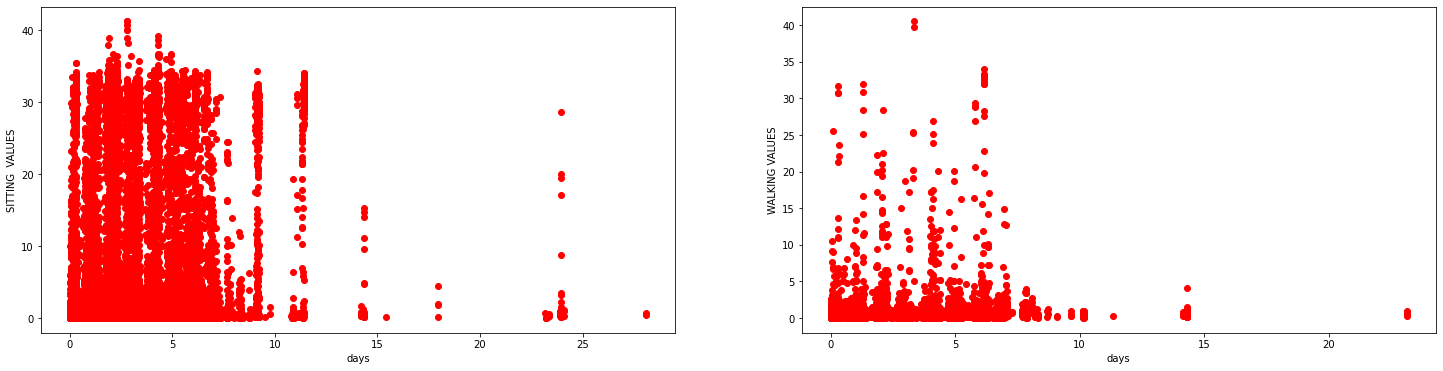

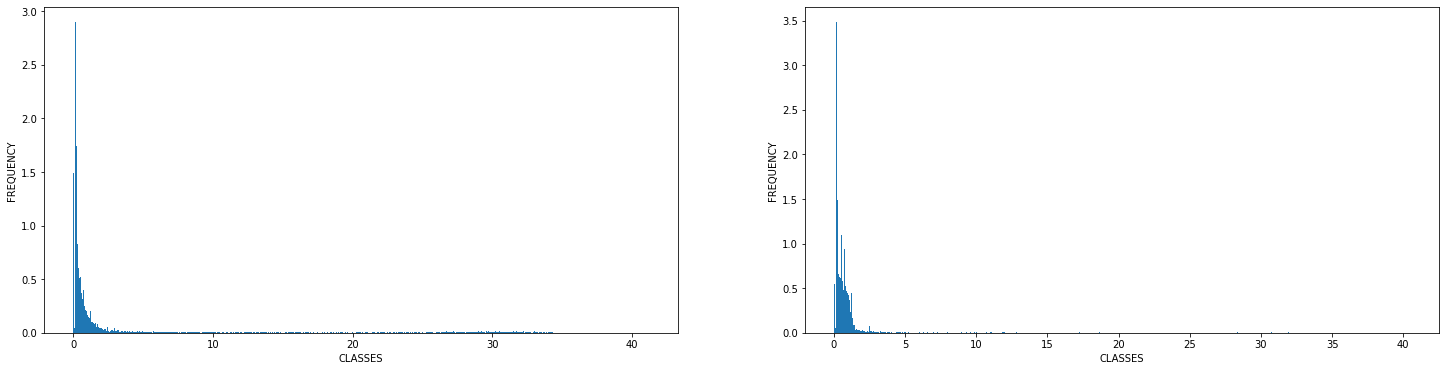

In [ ]:
# location:min_speed: its index is 143
extract_data_and_graph_ALL(feature_index = 143)


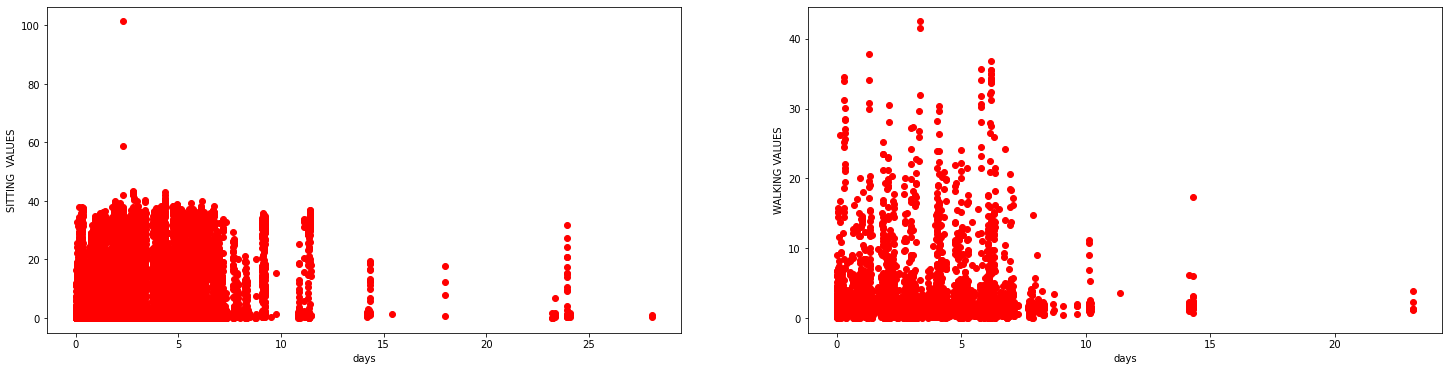

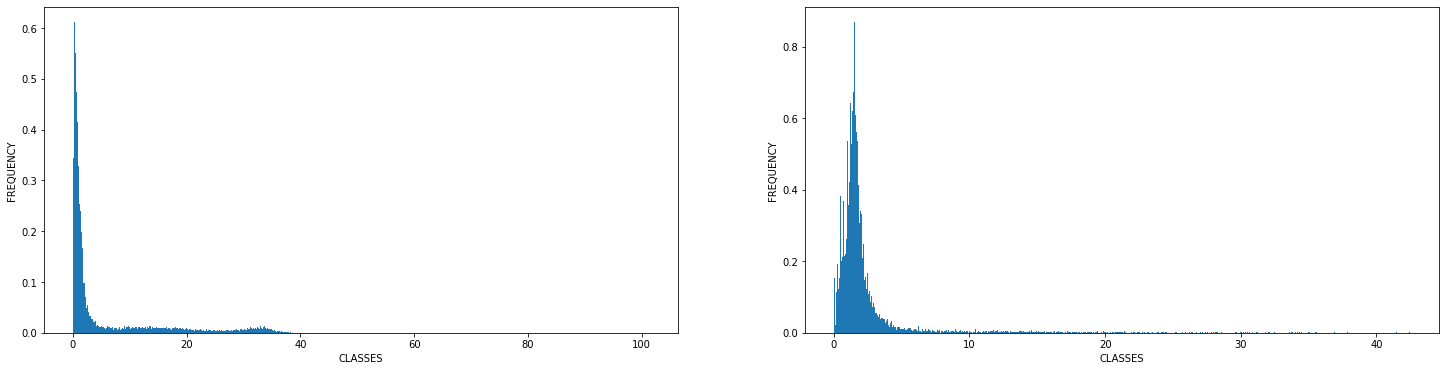

In [ ]:
# location:max_speed: its index is 144
extract_data_and_graph_ALL(feature_index = 144)


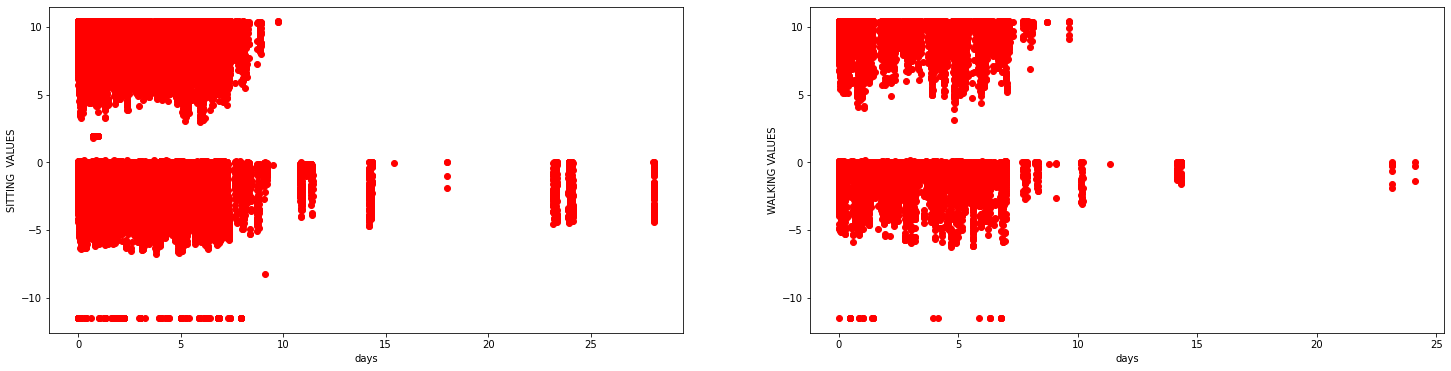

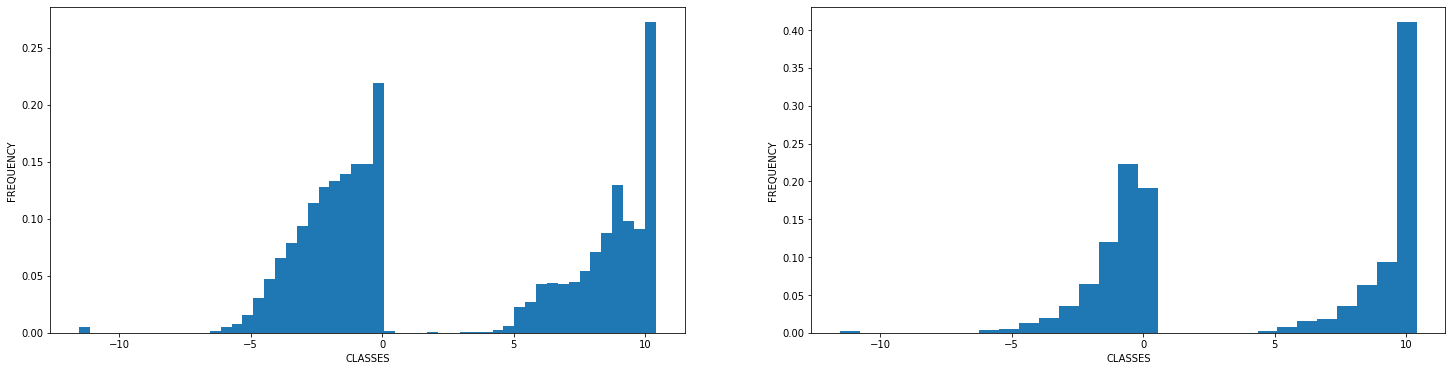

In [ ]:
#  audio_properties:max_abs_value: its index is 181
extract_data_and_graph_ALL(feature_index = 181)


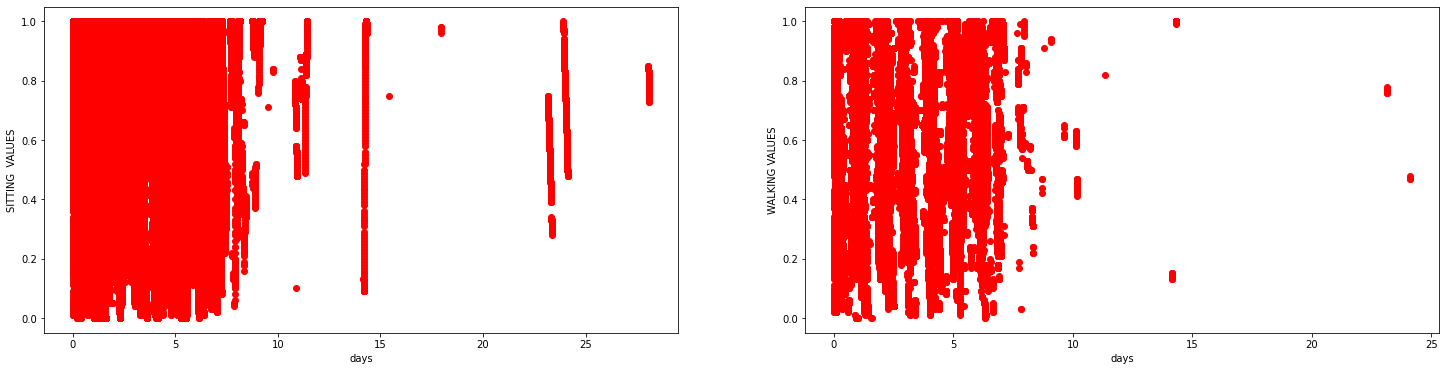

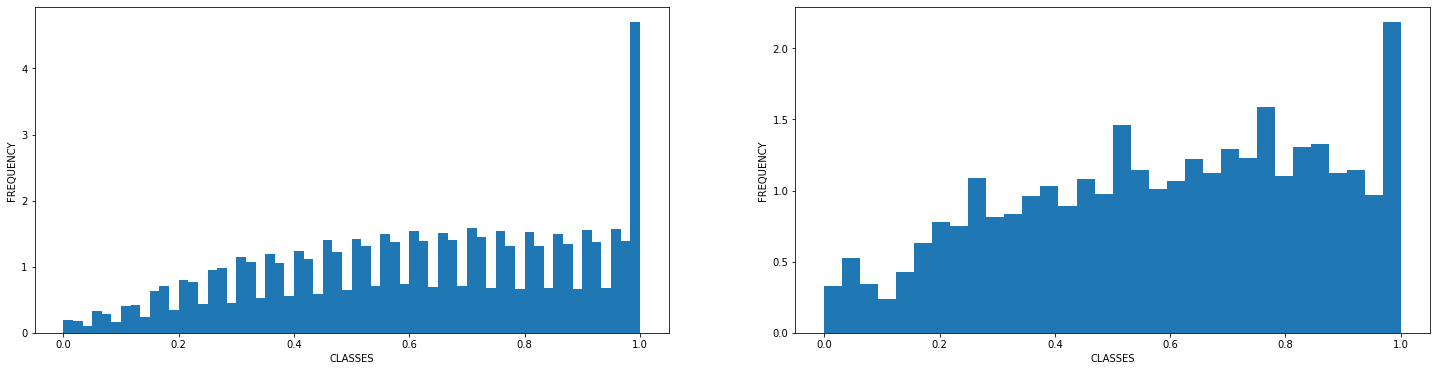

In [ ]:
# lf_measurements:battery_level: its index is 214

extract_data_and_graph_ALL(feature_index = 214)


## FINAL CONSIDERATION:

It seems that these plots confirmed what the plots related to the randomly chosen user said: the data are generally more numerous for the sitting activities but higher in value for the walking activities.